In [1]:
import csv
import cv2
import numpy as np
from enum import Enum, IntEnum, unique
import matplotlib.pyplot as plt
import time
import sys
import os, glob

from sklearn.model_selection import train_test_split
%matplotlib inline

####### ---- HYPERPARAMETERS AND GLOBAL CONSTANTS ------ ###########
DEBUG_SAMPLE_SIZE=10
BATCH_SIZE=128
NUM_EPOCHS=5
VALIDATION_SPLIT=0.2
LOSS_FUNC='mse'
OPTIMIZER='adam'
MODEL_FILE="model.h5"
STEERING_CORRECTION=0.2
NUM_AUGMENT_PER_SAMPLE=4
####### ---- HYPERPARAMETERS AND GLOBAL CONSTANTS ------ ###########



def LoadCSV (datafile) :
    lines = []
    with open (datafile) as csvfile :
        reader = csv.reader (csvfile)
        for line in reader :
	        lines.append (line)
    return lines


DRIVING_LOG_LOCATION='../data/driving_log.csv'
FILE_SEPARATOR='\\'
@unique
class DrvLogCols (IntEnum) :
    CENTER_IMAGE = 0
    LEFT_IMAGE = 1
    RIGHT_IMAGE = 2
    STEERING_ANGLE = 3
    @staticmethod
    def isValidImageIndex (imageIndex) :
       return {
           DrvLogCols.CENTER_IMAGE : True,
           DrvLogCols.LEFT_IMAGE : True,
           DrvLogCols.RIGHT_IMAGE : True,
       }.get(DrvLogCols(imageIndex), False)

def isNonImageFileName (filepath) :
    #Probably better to check for /, but works for the current project
    return "IMG" not in filepath.upper ()

def LoadImagesAndLabels (lines) :
    images = []
    labels = []
    count = 0
    print ("Loading Data set, number of lines = {}".format (len (lines)))
    for line in lines :
        image_loc = line[DrvLogCols.CENTER_IMAGE]
        # Hack to skip first line in example csv
        if isNonImageFileName (image_loc) :
            continue
        if (count < 1) :
            print ("image_loc = {}".format (image_loc))
        cent_img_file    = filename_from_location_path (line[DrvLogCols.CENTER_IMAGE])
        prefix = "../data/IMG/"
        left_img_file  = filename_from_location_path (line[DrvLogCols.LEFT_IMAGE])
        right_img_file = filename_from_location_path (line[DrvLogCols.RIGHT_IMAGE])

        if (count < 1) :
            print ("center filename = {}".format(cent_img_file))
            print ("left filename = {}".format(left_img_file))
            print ("right filename = {}".format(right_img_file))
        imageC = cv2.cvtColor (cv2.imread(prefix+cent_img_file), cv2.COLOR_BGR2RGB)
        imageL = cv2.cvtColor (cv2.imread(prefix+left_img_file), cv2.COLOR_BGR2RGB)
        imageR = cv2.cvtColor (cv2.imread(prefix+right_img_file), cv2.COLOR_BGR2RGB)
        imageF = np.fliplr (imageC)
        images.append (imageC)
        images.append (imageL)
        images.append (imageR)
        images.append (imageF)
        images.append (np.fliplr(imageL))
        images.append (np.fliplr(imageR))
        label = float(line[DrvLogCols.STEERING_ANGLE])
        labels.append (label)
        labels.append (label + STEERING_CORRECTION)
        labels.append (label - STEERING_CORRECTION)
        labels.append (-label)
        labels.append (-label - STEERING_CORRECTION)
        labels.append (-label + STEERING_CORRECTION)
        count += 1
    return np.array(images), np.array(labels)

def filename_from_location_path (location_path) :
    return location_path.split(FILE_SEPARATOR)[-1]



In [2]:
def rm_models (model_file) :
    try:
        for f in glob.glob(model_file):            
            os.remove(f)
            print ("Removed {}".format (f))
        for f in glob.glob("checkpoint"):
            print ("Removed {}".format(f))
            os.remove(f)
    except:
        print("Unable to delete file.")




In [3]:
#### --- START DEBUG CODE --- ####
def DumpLines (lines) :
    print ("SDC_DEBUG: Dumping lines")
    for i in range (min (len(lines),DEBUG_SAMPLE_SIZE)):
        print (lines[i])

#### --- END DEBUG CODE --- ####

def choose_random_subset (X, y, sample_size) :
    rand_indxs = np.random.choice(len(X), sample_size, replace=False)
    X_sample = X[rand_indxs]
    y_sample = y[rand_indxs]
    return X_sample, y_sample

def choose_first_subset (X, y, subset_size) :
    subset_len = min (len (X), subset_size)
    return X[0:subset_len,...], y[0:subset_len]

def choose_subset (X, y, subset_size) :
    #return choose_random_subset (X, y, subset_size)
    return choose_first_subset (X, y, subset_size)
 

In [4]:
#### --- Machine Learning Part. Train the model.
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Convolution2D, MaxPooling2D, Cropping2D, Dropout

def trainNvidiaModel (X_train, y_train, model_file) :
    model = Sequential ()
    model.add (Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
    model.add (Cropping2D(cropping=((70, 25), (0, 0))))
    model.add (Convolution2D (24, 5, 5, subsample=(2,2), activation="relu"))
    model.add (Convolution2D (36, 5, 5, subsample=(2,2), activation="relu"))
    model.add (Convolution2D (48, 5, 5, subsample=(2,2), activation="relu"))
    model.add (Convolution2D (64, 3, 3, activation="relu"))
    model.add (Convolution2D (64, 3, 3, activation="relu"))
    model.add (Flatten())
    model.add (Dense(50))
    model.add (Dropout(0.5))
    model.add (Dense(50))
    model.add (Dropout(0.5))
    model.add (Dense(10))
    model.add (Dense(1))

    model.compile (loss=LOSS_FUNC, optimizer=OPTIMIZER)
    model.fit (X_train, y_train, validation_split=VALIDATION_SPLIT, shuffle=True, nb_epoch=NUM_EPOCHS)
    rm_models (model_file)
    model.save (model_file)


def trainModel (X_train, y_train, model_file) :
    #trainSimpleModel (X_train, y_train, model_file)
    #trainLenetModel (X_train, y_train, model_file)
    trainNvidiaModel (X_train, y_train, model_file)




Using TensorFlow backend.


In [5]:
# Main
def MyMain () :
    print ("HELLO!")
    lines = LoadCSV (DRIVING_LOG_LOCATION)
    #DumpLines (lines)
    #sys.exit (1)
    X_train, y_train = LoadImagesAndLabels (lines[0:10])
    print ("Number of Images Loaded is {}".format (len (X_train)))
    print ("Number of Labels is {}".format  (y_train.shape))
    #X_train, y_train = choose_subset (X_train, y_train, DEBUG_SAMPLE_SIZE)
    #X_train = normalizeImgDataSet (X_train)
    #
    #for i in range(len (y_train)) :
    #    print ("Steering angle is {}".format (y_train [i]))
    #trainModel (X_train, y_train, MODEL_FILE)
    return X_train, y_train, lines
X_train, y_train, lines = MyMain ()

HELLO!
Loading Data set, number of lines = 10
image_loc = C:\Users\shashigk\Desktop\sdc_train\d7\IMG\center_2017_04_15_22_41_47_207.jpg
center filename = center_2017_04_15_22_41_47_207.jpg
left filename = left_2017_04_15_22_41_47_207.jpg
right filename = right_2017_04_15_22_41_47_207.jpg
Number of Images Loaded is 60
Number of Labels is (60,)


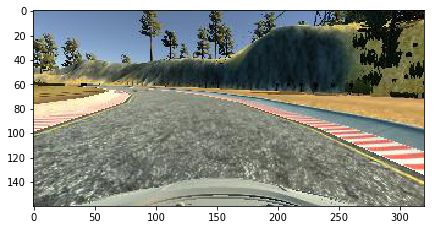

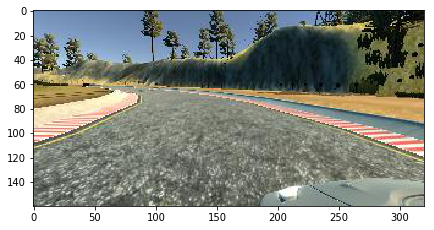

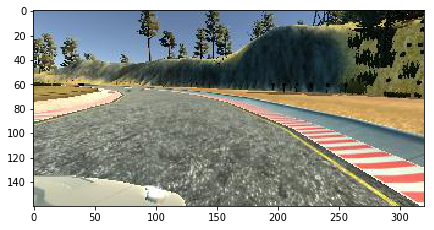

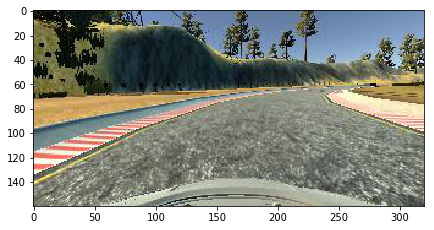

In [6]:
plt.figure(figsize=(7, 7))
plt.imshow(X_train[0])
plt.figure(figsize=(7, 7))
plt.imshow(X_train[1])
plt.figure(figsize=(7, 7))
plt.imshow(X_train[2])
plt.figure(figsize=(7, 7))
plt.imshow(X_train[3])


 

In [13]:
# Loading all images on the local computer is memory intense.
# So load all the training labels and plot the histogram
def displaySteeringAngleDistribution (lines) :
    orig_angles = []
    augm_angles = []
    for line in lines :
        image_loc = line[DrvLogCols.CENTER_IMAGE]
        # Hack to skip first line in example csv
        if isNonImageFileName (image_loc) :
            continue        
        label = float(line[DrvLogCols.STEERING_ANGLE])
        orig_angles.append (label)
        augm_angles.append (label)
        augm_angles.append (label + STEERING_CORRECTION)
        augm_angles.append (label - STEERING_CORRECTION)
        augm_angles.append (-label)
        augm_angles.append (-label - STEERING_CORRECTION)
        augm_angles.append (-label + STEERING_CORRECTION)
    plt.figure (figsize=(10,10))
    plt.hist (orig_angles,bins=50)
    plt.figure (figsize=(10,10))
    plt.hist (augm_angles,bins=50)

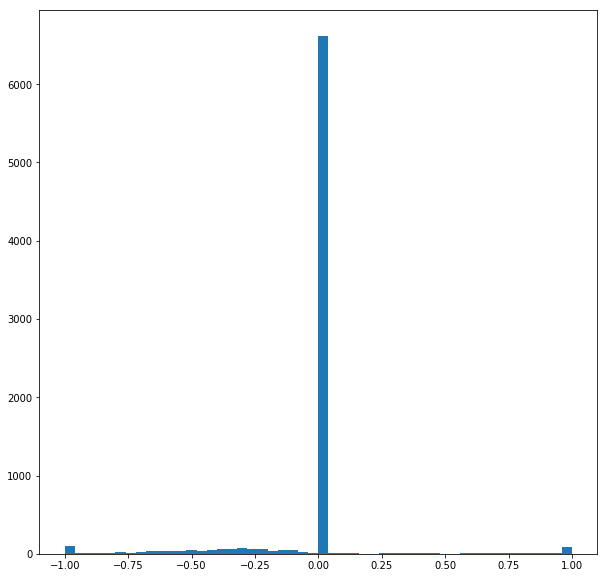

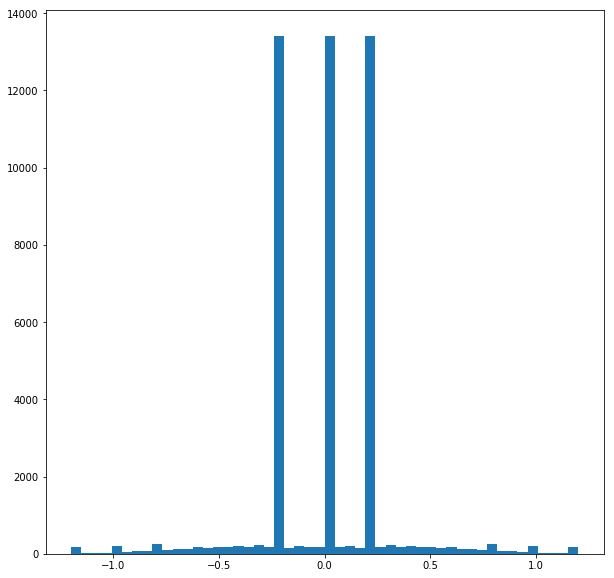

In [14]:
displaySteeringAngleDistribution (lines)